# Overview

This notebook contains evaluation logic for trained neural network.

## Imports

Firstly let's import all required packages.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from math import ceil

from model import Net
from datamodule import FacialKeypointsDatamodule

from PIL import Image

from pytorch_lightning import Trainer

from dataset import FacialKeypointsDataset
from torchvision.transforms import Compose
from transforms import ToTensor, Rescale, RandomCrop, Normalize

## Data

Before obtaining key-points within model we have to define all required transformations and create an instance of DataModule.

In [2]:
transformations = Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

dm = FacialKeypointsDatamodule(
    root_dir='./data/',
    train_csv_file='./data/training_frames_keypoints.csv',
    test_csv_file='./data/test_frames_keypoints.csv',
    num_workers=8
)

## Model

Since the repository contains weights we can use them for obtaining key-points by photo.

In [3]:
model = Net.load_from_checkpoint('./lightning_logs/version_13/checkpoints/epoch=199.ckpt')

## Evaluation

Having model and data module we can see what the model can do with images. Let's load batch of images using test data loader and try to obtain key-points.

In [4]:
def net_sample_output(data_loader):    
    images, key_pts = next(iter(data_loader))
    
    # convert images to FloatTensors
    images = images.type(torch.FloatTensor)

    # forward pass to get net output
    output_pts = model(images)
    
    # reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    key_pts = key_pts.view(key_pts.size()[0], 68, -1)
    
    return images, output_pts, key_pts            

In [5]:
test_images, test_outputs, gt_pts = net_sample_output(dm.test_dataloader())

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


Next step is visual validation. Now we can show images with predicted/original key-points and compare how close they are.

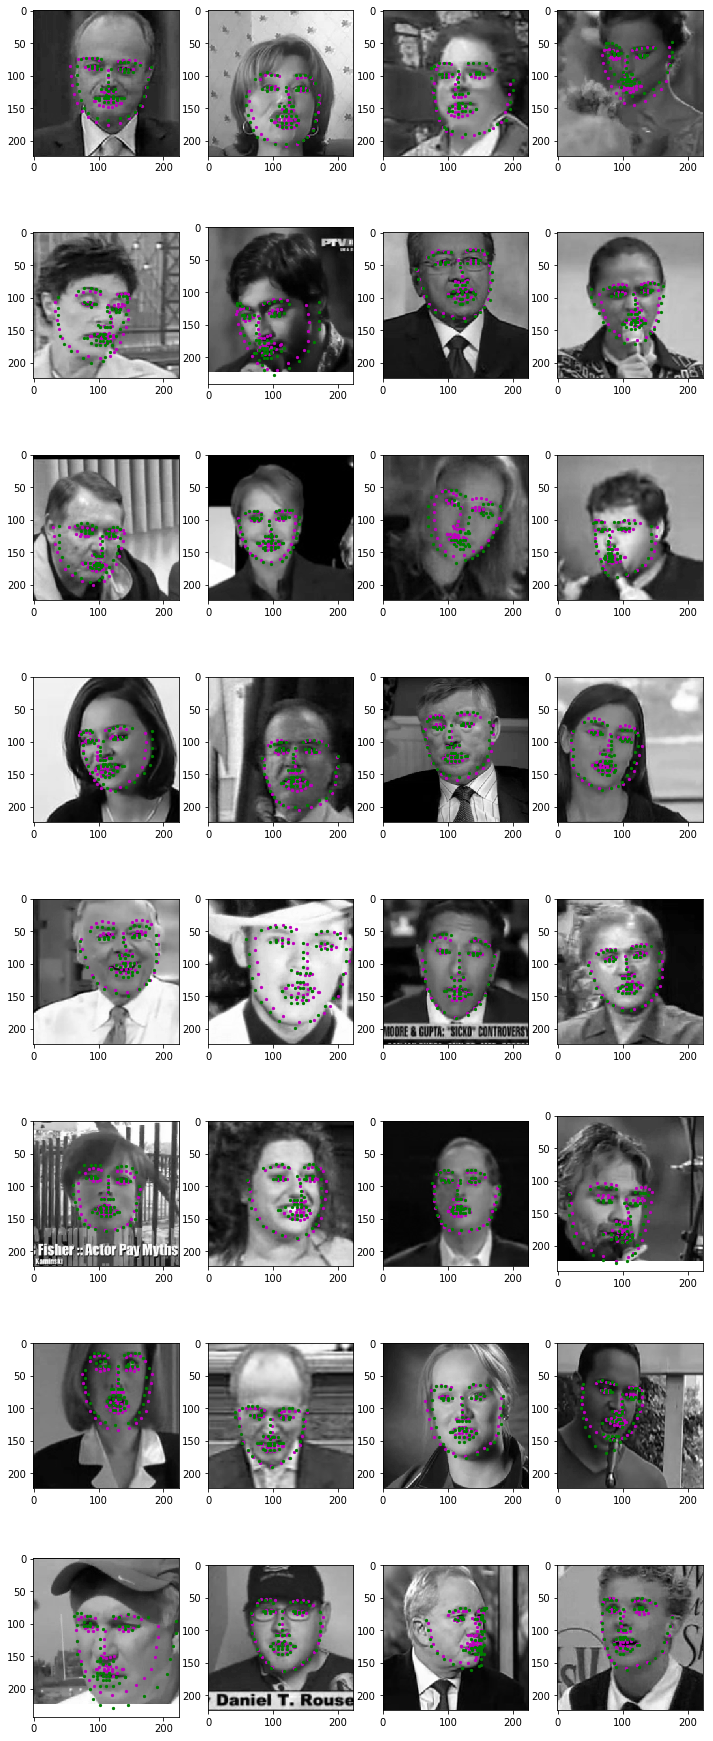

In [6]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(images, output, gt_pts=None, batch_size=32):

    cols = 4
    rows = ceil(batch_size / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, cols * rows))
    
    for r in range(rows):
        for c in range(cols):
            
            idx = r * cols + c
            
            if idx >= batch_size:
                break
            
            ax = axes[r, c]
            image = images[idx]
            predicted_key_points = output[idx].data.numpy()
            predicted_key_points = predicted_key_points * 50.0 + 100
            
            ax.imshow(image.squeeze(), cmap='gray')
            ax.scatter(predicted_key_points[:, 0], predicted_key_points[:, 1], s=20, marker='.', c='m')
            
            if gt_pts is not None:
                true_points = gt_pts[idx].data.numpy()
                true_points = true_points * 50.0 + 100
                ax.scatter(true_points[:, 0], true_points[:, 1], s=20, marker='.', c='g')
            
        
    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size=32)

So far looks good. Next step is to try the model on a image from the internet.

In [7]:
image_path = './images/average_face.jpg'

image = np.copy(np.asarray(Image.open(image_path).convert('L')))

sample = (image, None)

image_tensor, _ = transformations(sample)
image_tensor = image_tensor.type(torch.FloatTensor).unsqueeze(0)

result_pts = model(image_tensor)
result_pts = result_pts * 50.0 + 100
result_pts = result_pts.view((68, -1)).data.numpy()

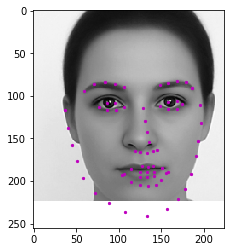

In [8]:
plt.imshow(image_tensor.squeeze(), cmap='gray')
plt.scatter(result_pts[:, 0], result_pts[:, 1], s=20, marker='.', c='m')

## Results

In most cases the model performs good. It can detect head turn and tilt, and it detects contours of face almost perfect. However, from time to time there are some problems with eyes, mouth and nose detection.